# **Financial Analysis Sandbox (WORK IN PROGRESS)**

This project is a sandbox of financial data analysis using Python. There is no particular purpose behind it, other than using Python to perform basic financial data analysis tasks.

In [4]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings as wrn
import riskfolio as rsk
import pypfopt as ppf
import yfinance as yf

np.random.seed(30)
palette = sns.color_palette("viridis_r", as_cmap=True)
sns.set_style(style = "whitegrid", rc = {"font.family":"Times New Roman", "font.weight":"bold"})
wrn.filterwarnings(action = "ignore")

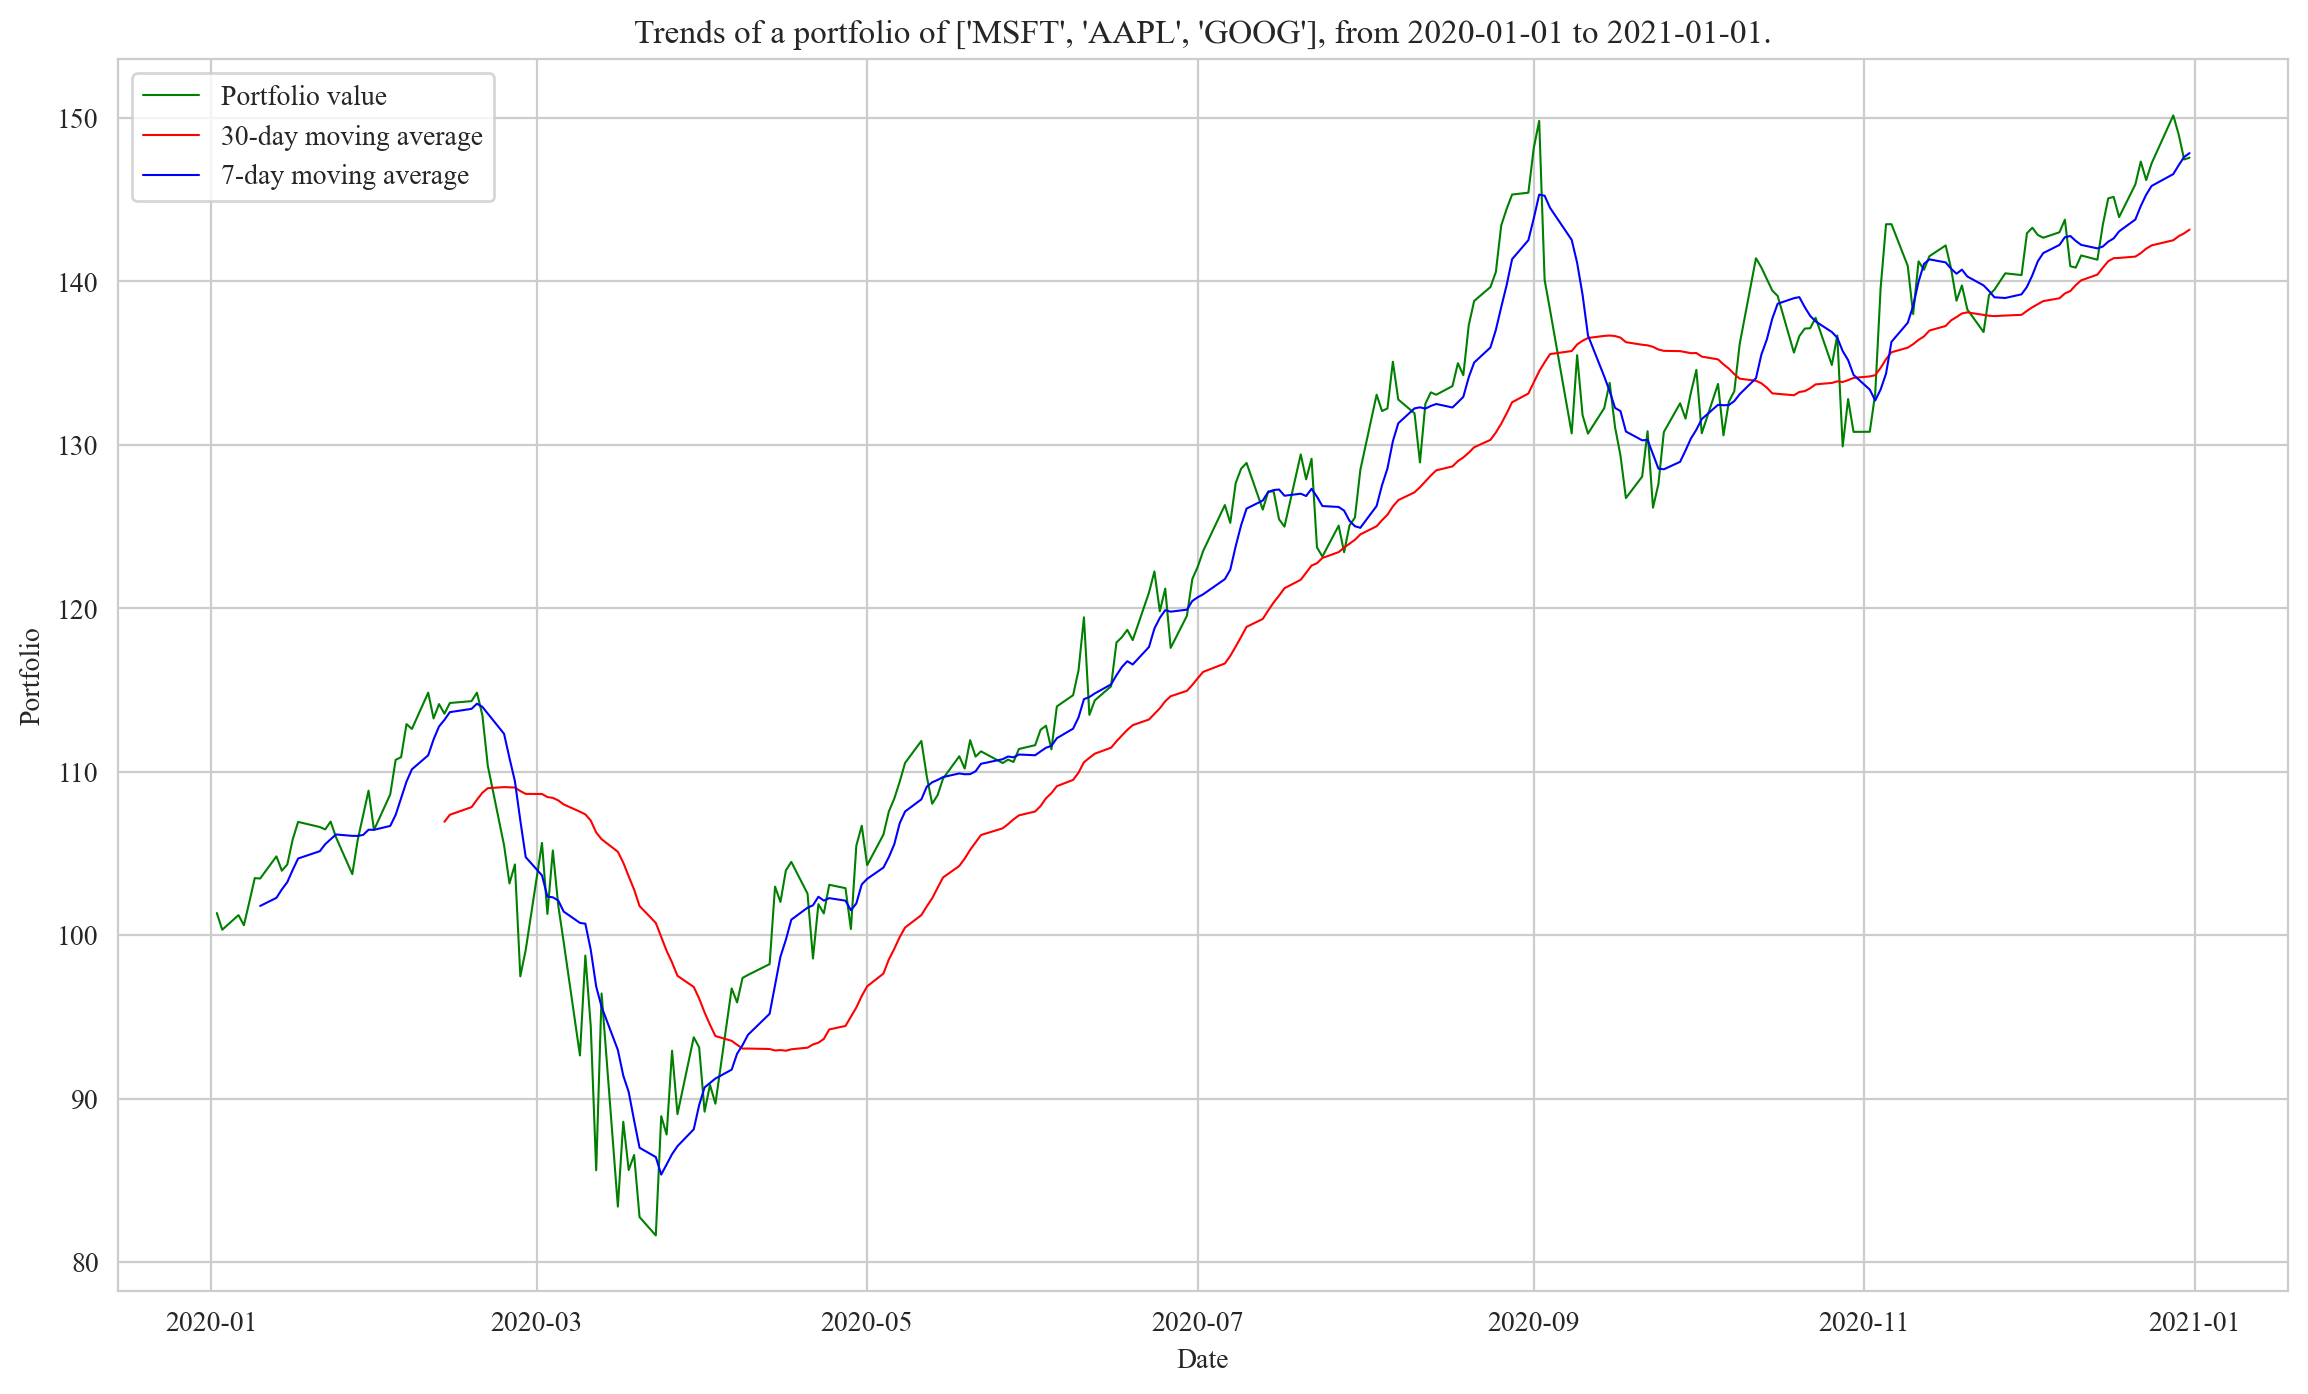

Date
2020-01-02    101.358665
2020-01-03    100.336830
2020-01-06    101.230166
2020-01-07    100.614835
2020-01-08    102.034500
                 ...    
2020-12-24    147.220833
2020-12-28    150.151502
2020-12-29    148.985329
2020-12-30    147.458664
2020-12-31    147.568001
Name: Portfolio, Length: 253, dtype: float64

In [5]:
def trend_following(tickers, weights, start_date, end_date, lower_window, upper_window):
    df = yf.download(tickers, start_date, end_date, progress=False)["Close"]
    df["Portfolio"] = np.dot(weights, df.T)
    df["Lower"] = df["Portfolio"].rolling(lower_window).mean()
    df["Upper"] = df["Portfolio"].rolling(upper_window).mean()
    plt.figure(figsize=(14, 8), dpi=200)
    for s, c, label in zip(["Portfolio", "Upper", "Lower"], ["green", "red", "blue"], ["Portfolio value", f"{upper_window}-day moving average", f"{lower_window}-day moving average"]):
        sns.lineplot(data=df, x=df.index, y=s, linewidth=0.75, color=c, alpha=1, label=label)
    plt.legend()
    plt.title(f"Trends of a portfolio of {tickers}, from {start_date} to {end_date}.")
    plt.show()
    return df["Portfolio"]

tickers = ["MSFT", "AAPL", "GOOG"]
start_date = "2020-01-01"
end_date = "2021-01-01"
N = len(tickers)
weights = np.ones(N) / N
trend_following(tickers, weights, start_date, end_date, 7, 30)

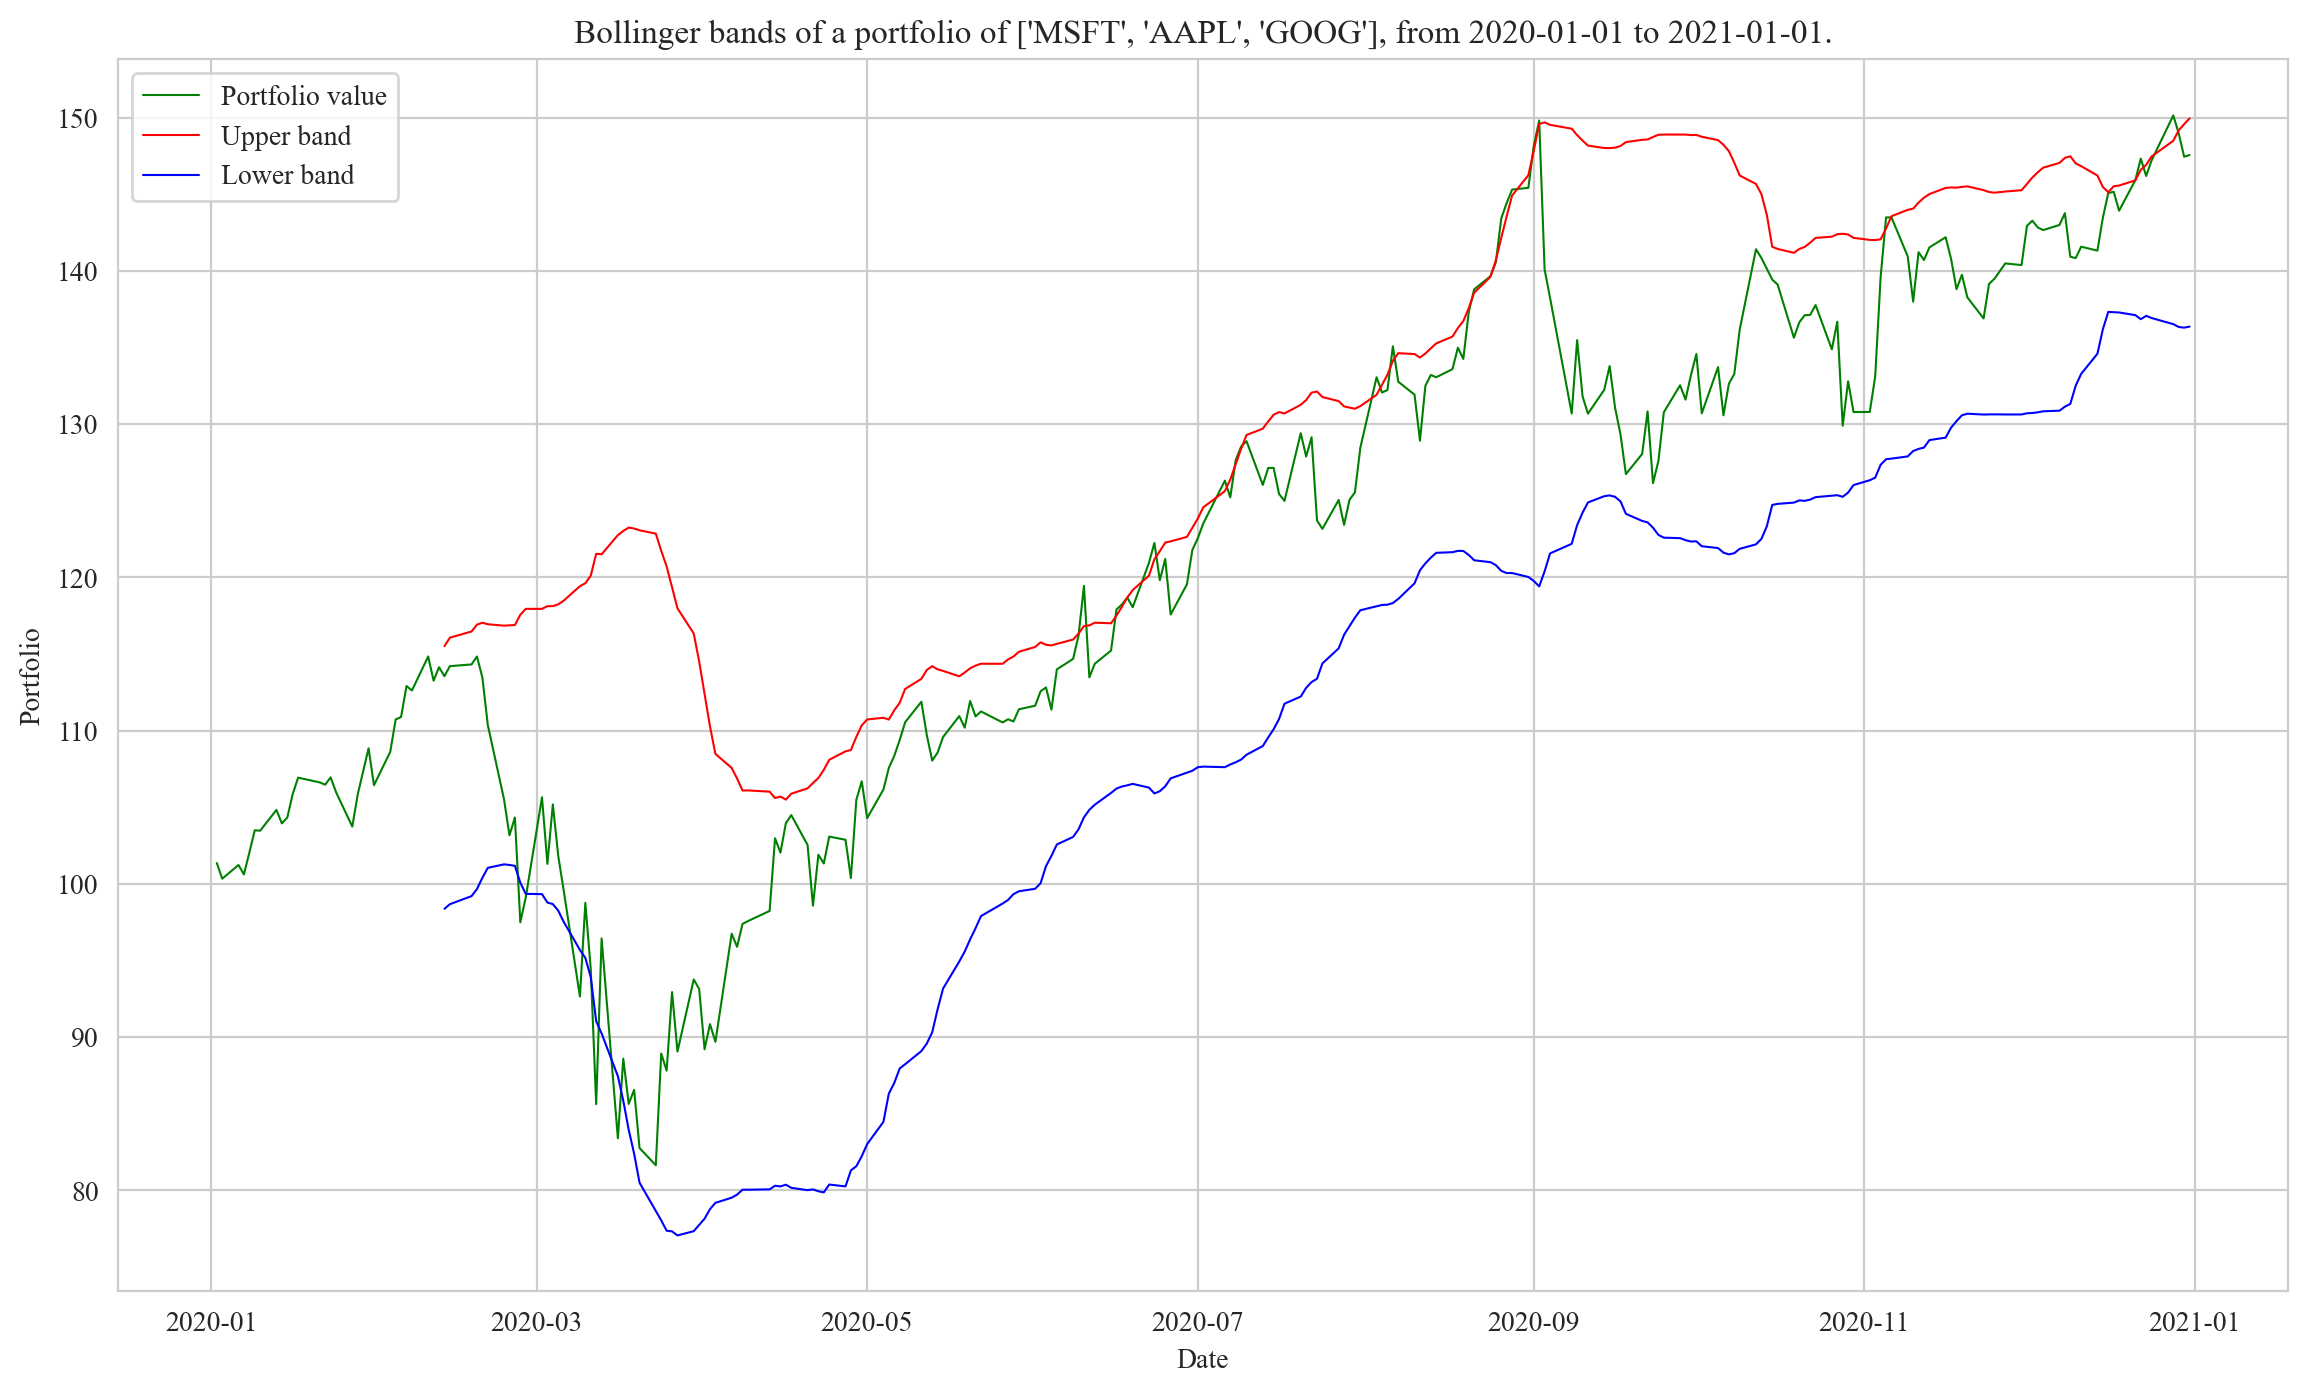

Date
2020-01-02    101.358665
2020-01-03    100.336830
2020-01-06    101.230166
2020-01-07    100.614835
2020-01-08    102.034500
                 ...    
2020-12-24    147.220833
2020-12-28    150.151502
2020-12-29    148.985329
2020-12-30    147.458664
2020-12-31    147.568001
Name: Portfolio, Length: 253, dtype: float64

In [6]:
def bollinger_bands(tickers, weights, start_date, end_date, window_length):
    df = yf.download(tickers, start_date, end_date, progress = False)["Close"]
    df["Portfolio"] = np.dot(weights, df.T)
    df["Rolling_Mean"] = df["Portfolio"].rolling(window_length).mean()
    df["Rolling_Standard_Deviation"] = df["Portfolio"].rolling(window_length).std()
    df["Upper"] = df["Rolling_Mean"] + 2 * df["Rolling_Standard_Deviation"]
    df["Lower"] = df["Rolling_Mean"] - 2 * df["Rolling_Standard_Deviation"]
    plt.figure(figsize=(14, 8), dpi=200)
    for s, c, label in zip(["Portfolio", "Upper", "Lower"], ["green", "red", "blue"], ["Portfolio value", f"Upper band", f"Lower band"]):
        sns.lineplot(data=df, x=df.index, y=s, linewidth=0.75, color=c, alpha=1, label=label)
    plt.legend()
    plt.title(f"Bollinger bands of a portfolio of {tickers}, from {start_date} to {end_date}.")
    plt.show()
    return df["Portfolio"]

tickers = ["MSFT", "AAPL", "GOOG"]
start_date = "2020-01-01"
end_date = "2021-01-01"
N = len(tickers)
weights = np.ones(N) / N
bollinger_bands(tickers, weights, start_date, end_date, 30)